In [109]:
%matplotlib inline

In [110]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

In [113]:
niv = pd.read_csv('data/corona_tested_individuals_ver_0034.csv.gz', 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-06-28,0,0,0,0,0,שלילי,No,זכר,Other
1,2020-06-28,0,0,0,0,0,שלילי,No,נקבה,Other
2,2020-06-28,0,0,0,0,0,שלילי,No,זכר,Other
3,2020-06-28,0,0,0,0,0,שלילי,No,NaN,Other
4,2020-06-28,0,0,0,0,0,שלילי,No,זכר,Other


In [114]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [115]:
bdi = pd.read_csv('data/corona_lab_tests_ver_0026.csv.gz', encoding='utf-8', parse_dates=[0,1])

In [116]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [117]:
bdi.head()

,test_date,result_date,corona_result,lab_id,is_first_Test,orig_test_date
0,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
1,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
2,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
3,2020-03-11,2020-03-11,שלילי,2,Yes,NaT
4,2020-03-11,2020-03-11,שלילי,2,Yes,NaT


In [118]:
bdi.shape

(955007, 6)

In [119]:
bdi.corona_result.value_counts()

שלילי               893687
חיובי                45973
לא בוצע/פסול 999     11178
חיובי גבולי           3168
בעבודה                 605
לא ודאי                396
Name: corona_result, dtype: int64

In [120]:
niv.corona_result.value_counts()

שלילי    671779
חיובי     21768
אחר        7943
Name: corona_result, dtype: int64

In [121]:
niv.test_indication.value_counts()

Other                     658515
Abroad                     27357
Contact with confirmed     15618
Name: test_indication, dtype: int64

In [122]:
niv.age_60_and_above.value_counts()

No     194164
Yes     36993
Name: age_60_and_above, dtype: int64

In [123]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [124]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [125]:
bdi['corona_result'] = bdi.corona_result.map(result_map)

In [126]:
rec = pd.read_csv('data/corona_recovered_ver_0025.csv.gz', encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,NaN,Abroad
1,22,9,30-39,NaN,Contact with confirmed
2,26,9,30-39,NaN,Contact with confirmed
3,28,9,30-39,NaN,Abroad
4,23,9,20-29,NaN,Contact with confirmed


In [127]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

,total_tests_count,size,min,max,mean,median,test_sum
0,2,7,1,15,6.857143,6.0,14
1,3,7436,2,76,15.972835,16.0,22308
2,4,3149,2,98,20.443950,20.0,12596
3,5,2219,4,76,23.995944,24.0,11095
4,6,1375,6,69,27.200727,27.0,8250
5,7,877,8,63,30.264538,30.0,6139
6,8,520,3,68,32.940385,32.5,4160
7,9,315,2,78,35.546032,35.0,2835
8,10,529,5,106,40.746692,40.0,5290


In [157]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
15947,106,10+,0-19,NaN,Contact with confirmed
16195,100,10+,60+,NaN,Contact with confirmed
16179,99,10+,60+,NaN,Other
5497,98,4,40-49,NaN,Other
7771,83,4,20-29,NaN,Other
273,78,9,60+,NaN,Contact with confirmed
15962,78,10+,0-19,NaN,Other
16148,78,10+,60+,NaN,Other
16284,77,10+,60+,NaN,Contact with confirmed
3322,76,5,0-19,NaN,Contact with confirmed


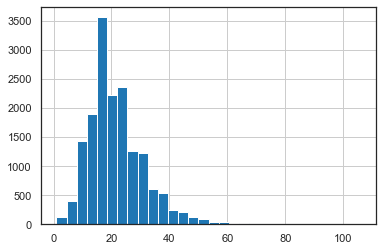

In [129]:
rec.days_between_pos_and_neg.hist(bins=30)

In [130]:
iso = pd.read_csv('data/corona_isolation_per_day_ver_0026.csv.gz',
                  encoding='utf-8-sig', low_memory=False)
iso.head()

,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad
0,2020-06-27,19551,7463,1731,338
1,2020-06-26,19165,7772,2601,797
2,2020-06-25,18789,8031,3065,673
3,2020-06-24,17254,7890,3091,299
4,2020-06-23,15685,8254,2769,327


In [131]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [132]:
niv.age_60_and_above.value_counts()

No     194164
Yes     36993
Name: age_60_and_above, dtype: int64

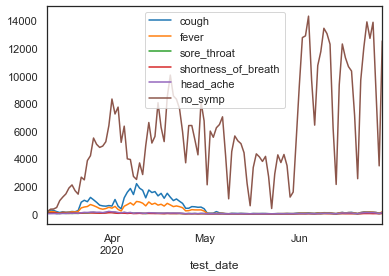

In [133]:
niv.groupby('test_date')[symptom_cols].sum().plot()

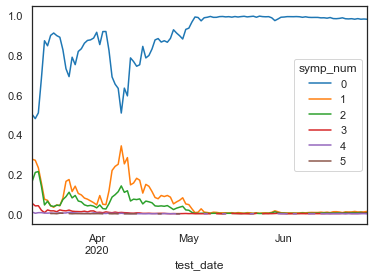

In [134]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

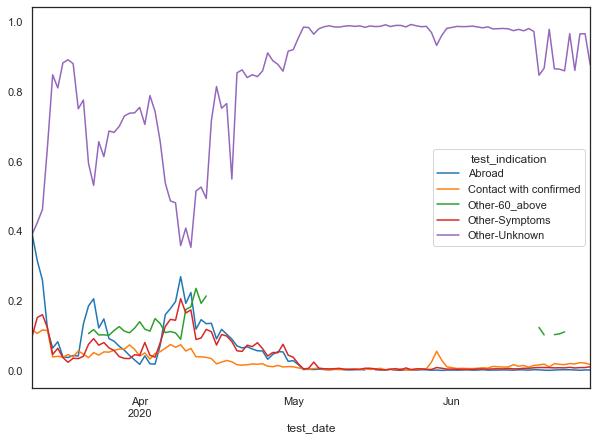

In [135]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

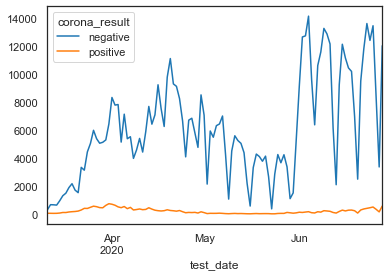

In [136]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [137]:
bdi.dtypes

test_date         datetime64[ns]
result_date       datetime64[ns]
corona_result             object
lab_id                     int64
is_first_Test             object
orig_test_date    datetime64[ns]
dtype: object

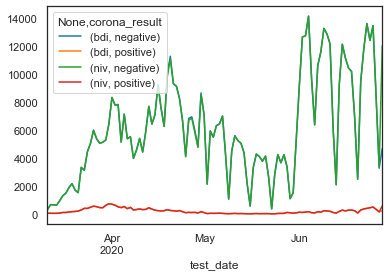

In [138]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

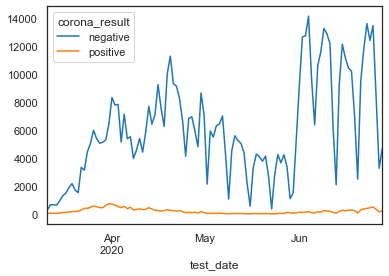

In [139]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [140]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='No')].groupby(['test_date', 'corona_result']).size().unstack()

corona_result,negative,positive
test_date,,
2020-03-11,2,3
2020-03-12,21,7
2020-03-13,21,2
2020-03-14,24,1
2020-03-15,70,47
...,...,...
2020-06-24,4690,234
2020-06-25,5936,253
2020-06-26,2424,163


In [141]:
pone = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-05-08,28.0,NaN,4199.0,18.0,NaN
2020-05-09,31.0,NaN,1057.0,9.0,NaN
2020-05-12,46.0,NaN,5250.0,19.0,NaN
2020-05-14,57.0,1.0,4379.0,16.0,NaN
2020-05-15,28.0,NaN,2183.0,7.0,NaN
2020-05-16,25.0,NaN,559.0,4.0,NaN
2020-05-17,58.0,NaN,3313.0,15.0,NaN
2020-05-19,32.0,NaN,4104.0,12.0,NaN
2020-05-20,42.0,NaN,3768.0,16.0,NaN


In [142]:
pone.tail(5)

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-06-24,76.0,6.0,12420.0,437.0,NaN
2020-06-25,144.0,NaN,13478.0,490.0,NaN
2020-06-26,163.0,NaN,8370.0,326.0,NaN
2020-06-27,35.0,NaN,3266.0,141.0,NaN
2020-06-28,80.0,NaN,4682.0,214.0,NaN


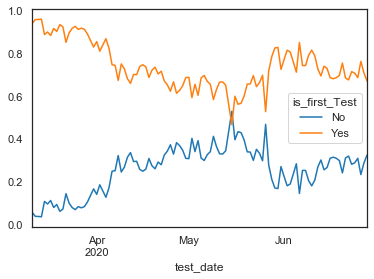

In [143]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

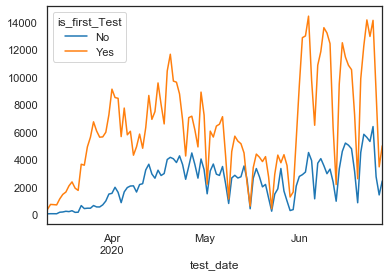

In [144]:
ti.plot()

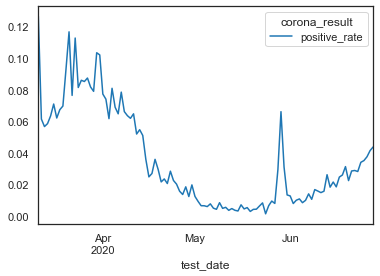

In [145]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']]
 .plot())

In [146]:
import altair as alt
ti.tail()

is_first_Test,No,Yes
test_date,,
2020-06-24,5290,12939
2020-06-25,6376,14112
2020-06-26,2723,8859
2020-06-27,1398,3442
2020-06-28,2412,4976


In [147]:
ti.Yes.sum() + ti.No.sum()

955007

In [148]:
alt.Chart(ti.reset_index().assign(total=lambda x: x.Yes+x.No)).mark_line().encode(
    x='test_date',
    y='Yes',
    tooltip=['test_date', 'Yes']
).interactive()

alt.Chart(...)

In [149]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [150]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [151]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'מונשמים': 'resp'}

In [152]:
hos = (pd.read_csv('data/corona_hospitalization_ver_0015.csv.gz', encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

,date,מאושפזים,אחוז נשים מאושפזות,גיל ממוצע מאושפזים,סטיית תקן גיל מאושפזים,resp,אחוז נשים מונשמות,גיל ממוצע מונשמים,סטיית תקן גיל מונשמים,חולים קל,...,גיל ממוצע חולים קל,סטיית תקן גיל חולים קל,חולים בינוני,אחוז נשים חולות בינוני,גיל ממוצע חולים בינוני,סטיית תקן גיל חולים בינוני,critical,אחוז נשים חולות קשה,גיל ממוצע חולים קשה,סטיית תקן גיל חולים קשה
0,2020-03-11,78,35.9,48.0,18.1,15,33.3,68.0,18.2,70,...,46.0,16.9,NaN,NaN,NaN,NaN,15,42.9,71.0,17.7
1,2020-03-12,100,39.0,50.0,18.5,15,33.3,68.0,18.2,92,...,48.0,17.8,NaN,NaN,NaN,NaN,15,42.9,71.0,17.7
2,2020-03-13,120,39.2,49.0,18.4,15,33.3,68.0,18.2,109,...,47.0,17.4,<15,50.0,64.0,17.3,15,42.9,71.0,17.7
3,2020-03-14,158,41.1,47.0,18.5,15,25.0,76.0,12.8,148,...,45.0,17.4,<15,50.0,64.0,17.3,15,33.3,79.0,11.4
4,2020-03-15,198,44.9,46.0,18.8,15,33.3,77.0,10.3,183,...,44.0,17.5,<15,50.0,58.0,14.9,15,44.4,80.0,9.7


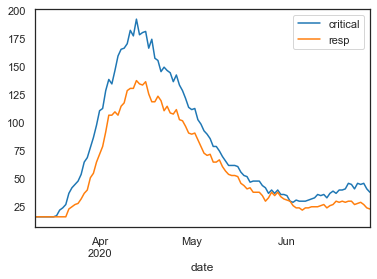

In [153]:
(hos[['date', 'critical', 'resp']].set_index('date').plot())

In [154]:
hos_and_rate = hos[['date', 'critical', 'resp']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


,test_date,critical,resp,negative,positive,positive_rate
0,2020-03-11,15,15,297,43,0.126471
1,2020-03-12,15,15,658,43,0.061341
2,2020-03-13,15,15,650,39,0.056604
3,2020-03-14,15,15,628,39,0.058471
4,2020-03-15,15,15,946,64,0.063366


In [155]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [156]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').encode()


alt.LayerChart(...)

No handles with labels found to put in legend.


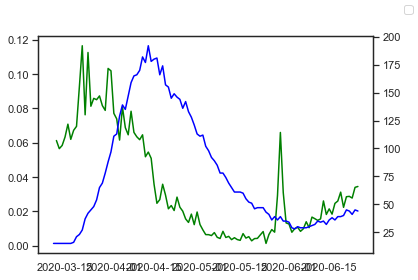

In [96]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()
